# Imputacion sobre datos de NHANES

## Preparacion del Entorno

### Librerias

In [2]:
import janitor  # limpiar datos
import matplotlib.pyplot as plt # visualizacion de datos
import missingno    # exploracion de valores faltantes
import nhanes.load  # libreria con los datos a analizar
import numpy as np  # calculos numericos
import pandas as pd # trabajar con dataframe
import scipy.stats  # trabjar con estadisticos
import seaborn as sns   #   visualizacion estadistica
# import session_info
# sklearn contiene los modelos a utilizar
import sklearn.compose
import sklearn.impute
import sklearn.preprocessing
import statsmodels.api as sm
import statsmodels.datasets
import statsmodels.formula.api as smf

from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import BayesianRidge, Ridge
from sklearn.neighbors import KNeighborsRegressor
from statsmodels.graphics.mosaicplot import mosaic

### Importar funciones personalizadas

In [3]:
# permite utilizar funciones contenidas en otro notebook
%run utils2.ipynb

### Configuracion de las graficas

In [4]:
%matplotlib inline

# tamaño de los graficos
sns.set(
    rc={
        'figure.figsize':(8, 6)
    }
)

# estilo de los graficos
sns.set_style('whitegrid')

## Preparando los Datos: National Health and Nutrition Examination Survey (NHANES)

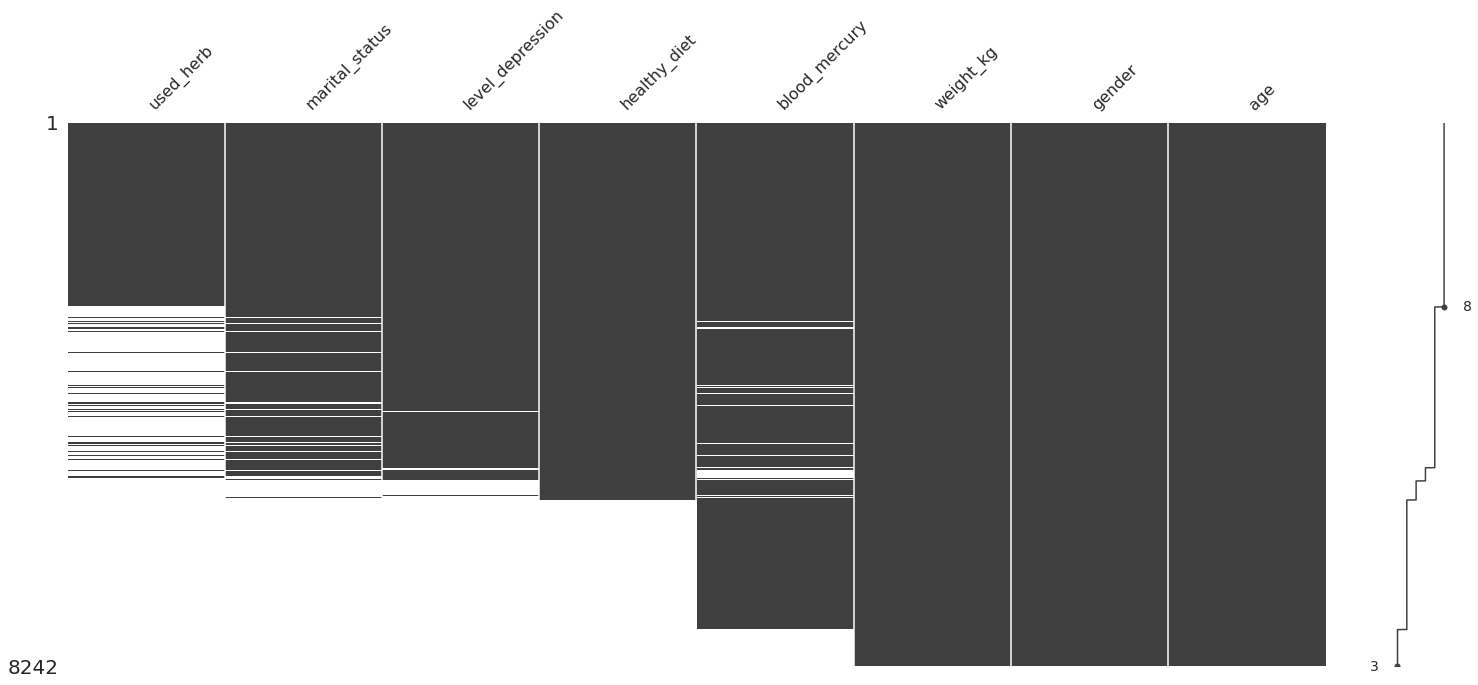

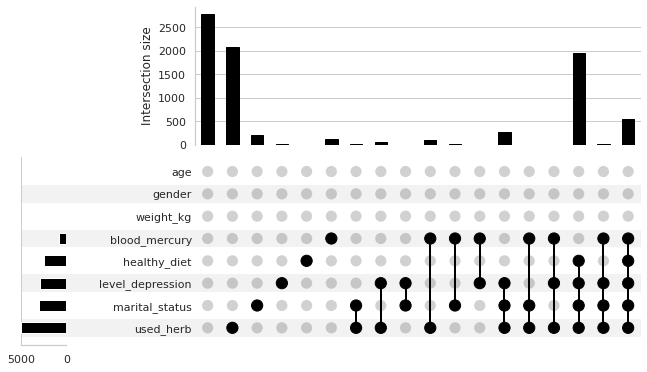

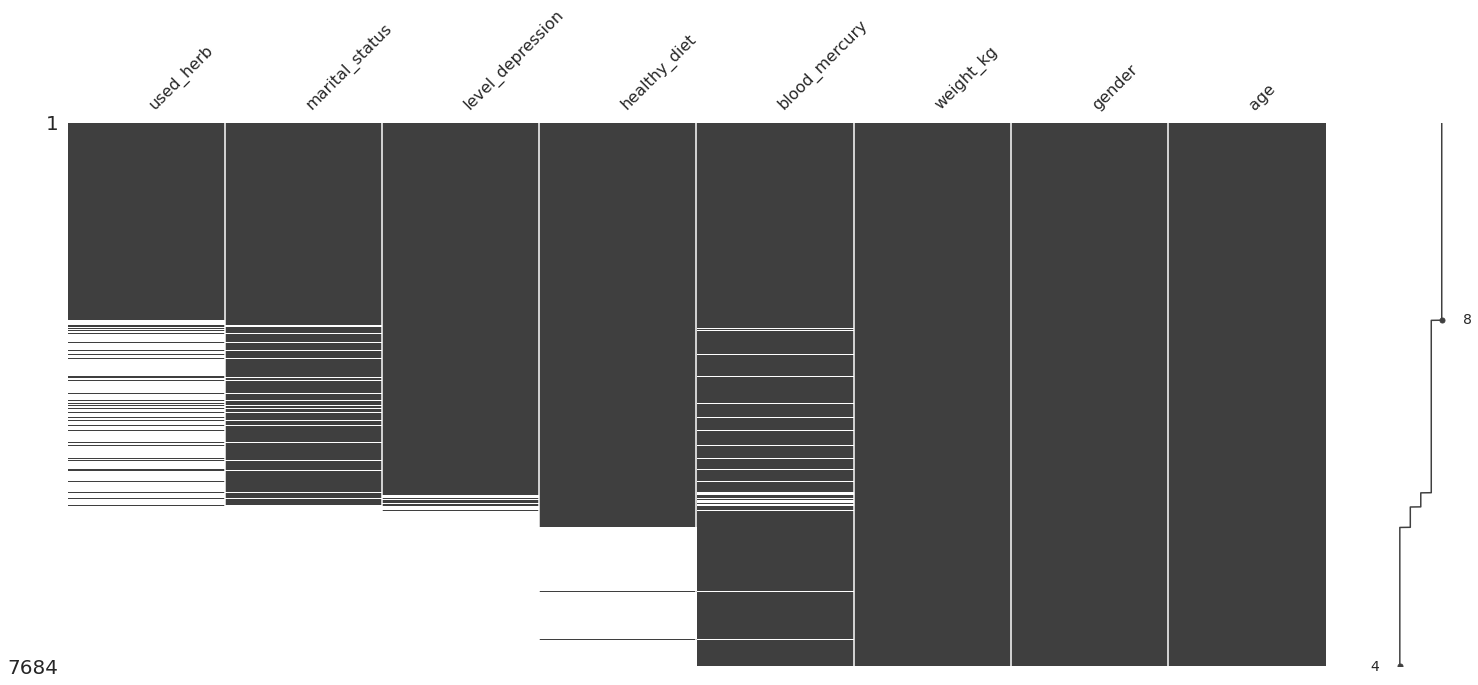

23.0 %


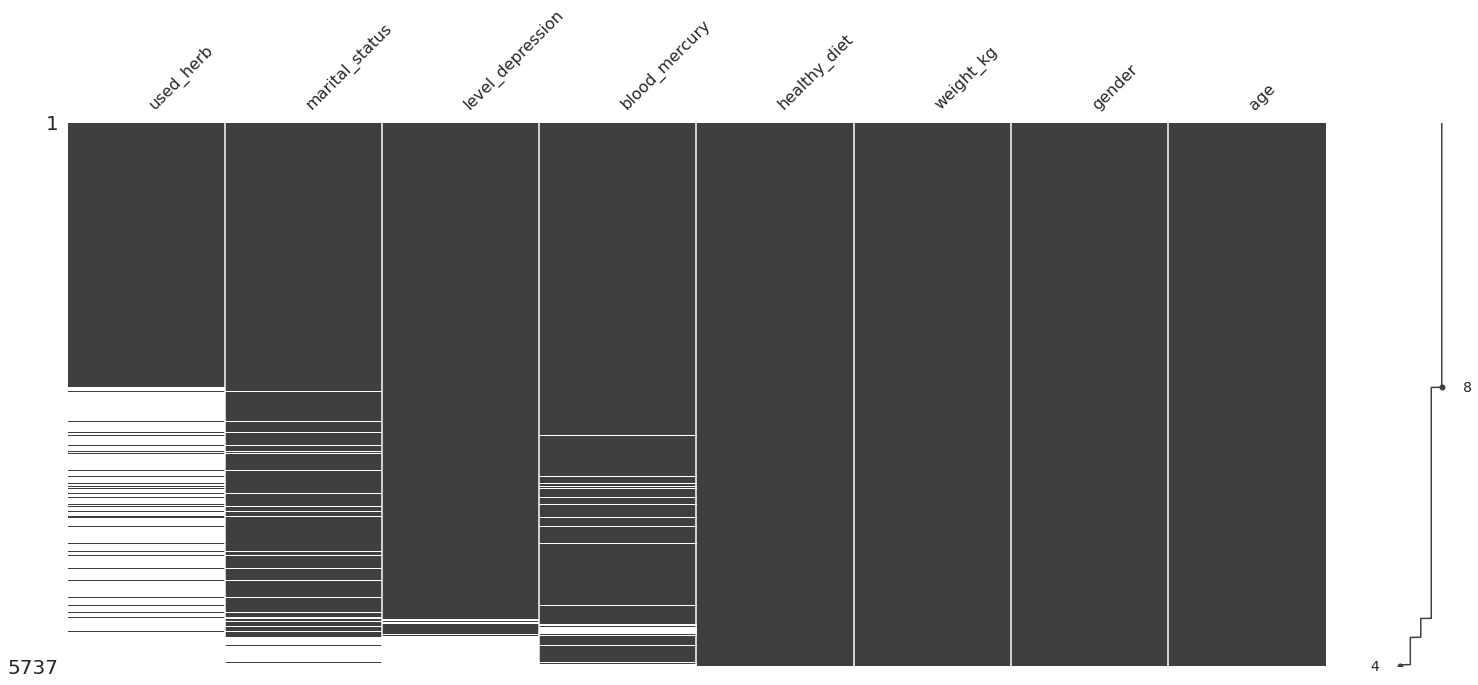

9.0 %


In [5]:
# cargar los datos externos
%run descarga_y_carga_datos.ipynb

## Analisis de los Tipos de Valores Faltantes

### Prueba de hipotesis con t-test

- Analicemos si existe alguna diferencia entre hombre y mujeres en funcion de la ausencia o presencia de valores faltantes en el consumo de hierbas.

In [9]:
# Creamos dos grupos a partir de la ausencia o precencia de missing en used_herb

female_herb, male_herb = (
    nhanes_df
    .select_columns('gender', 'used_herb') # extraer variables de interes
    .transform_column(  # transformar en booleanos los elementos de used_herb
        'used_herb',
        lambda x: x.isna(),
        elementwise = False
    )
    .groupby('gender')  # agrupar segun el genero
    .used_herb
    .pipe(
        lambda df:(
            df.get_group('Female'),
            df.get_group('Male')
        )
    )
)

In [10]:
# Aplicacion de la prueba t-test

# Hipotesis nula: No existe diferencia alguna entre hombres y mujeres segun los valores faltantes en used_herb
# Hipotesis alternativa: existe alguna diferencia entre hombres y mujeres segun los valores faltantes en used_herb

scipy.stats.ttest_ind(
    a = female_herb,
    b = male_herb,
    alternative='two-sided'
)

Ttest_indResult(statistic=-0.9813473437440827, pvalue=0.3264628792991634)

El valor de pvalue es de 0.32, mucho mayor al umbral de 0.05. Esto indica que no podemos rechazar la hipotesis nula, es decir, no hay suficientes pruebas que indican que haya alguna diferencia entre hombres y mujeres. La falta de respuestas en ambos grupos no es completamente al azar.

- Analicemos si existe alguna diferencia entre hombre y mujeres en funcion de la ausencia o presencia de valores faltantes en el estado marital.

In [13]:
# Creamos dos grupos a partir de la ausencia o precencia de missing en marital_status

female_status, male_status = (
    nhanes_df
    .select_columns('gender', 'marital_status')
    .transform_column(
        'marital_status',
        lambda x: x.isna(),
        elementwise = False
    )
    .groupby('gender')
    .marital_status
    .pipe(
        lambda df:(
            df.get_group('Female'),
            df.get_group('Male')
        )
    )
)

In [14]:
# aplicacion de la prueba t-test

# Hipotesis nula: No existe diferencia alguna entre hombres y mujeres en cuanto a la falta de respuesta de su estado marital
# Hipotesis alternativa: existe alguna diferencia entre hombres y mujeres.

scipy.stats.ttest_ind(
    a = female_status,
    b = male_status,
    alternative='two-sided'
)

Ttest_indResult(statistic=-0.7479621277949182, pvalue=0.45451367052393077)

El pvalues es mucho menor que el umbral (0.05) lo que indica que no se puede rechazar la hipotesis nula, es decir, no hay suficientes pruebas que aseguren alguna diferencia entre hombres y mujeres en cuanto a la falta de respuesta de su estado marital. La falta de respuesta no es completamente al azar.

- Analicemos si existe alguna diferencia entre hombres y mujeres en funcion de la ausencia o presencia de valores faltantes en el nivel de depresion.

In [15]:
# Creamos dos grupos a partir de la ausencia o precencia de missing en level_depression

female_depression, male_depression = (
    nhanes_df
    .select_columns('gender', 'level_depression')
    .transform_column(
        'level_depression',
        lambda x: x.isna(),
        elementwise = False
    )
    .groupby('gender')
    .level_depression
    .pipe(
        lambda df:(
            df.get_group('Female'),
            df.get_group('Male')
        )
    )
)

In [16]:
# aplicacion de la prueba t-test

# Hipotesis nula: No existe diferencia alguna entre hombres y mujeres en cuanto a la falta de respuesta de su nivel de depresion
# Hipotesis alternativa: existe alguna diferencia entre hombres y mujeres.

scipy.stats.ttest_ind(
    a = female_depression,
    b = male_depression,
    alternative='two-sided'
)

Ttest_indResult(statistic=-1.173376568574891, pvalue=0.2406935583186293)

El pvalue es mayor que el umbral, lo que indica que no hay suficientes pruebas para rechazar la hipotesis nula, es decir, no se puede asegurar que exista alguna diferencia entre hombres y mujeres en cuanto a la falta de respuesta de su nivel de depresion.

## Exploracion de la relacion entre variables categoricas y valores faltantes mediante un grafico de Mosaico

Este grafico trabaja con tres variables: 1 variable numerica, 1 variable categorica con solo 2 categorias y otra variable categorica. el uso de este tipos de variables asegura una optima visualizacion de las relaciones. Permite visualizar la relacion entre las tres variables dadas

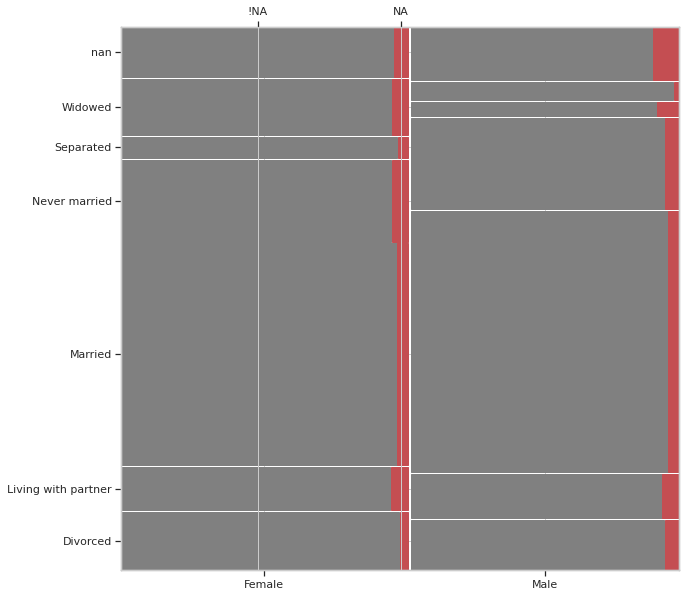

In [23]:
# variables: gender, blood_mercury, marital_status

# size de la grafica
fig, ax = plt.subplots(figsize=(10, 10))

(
    nhanes_df
    .select_columns('blood_mercury', 'marital_status', 'gender') # selecion de variables
    .assign( # asignamos NA y !NA a los valores de blood_mercury depediendo si hay o no missing
        blood_mercury = lambda df: df.blood_mercury.isna().replace([True, False], ['NA', '!NA'])
    )
    .groupby( # cuantificar las apariciones que existen por cada combinacion de las 3 variables
        ['gender', 'marital_status', 'blood_mercury'],
        dropna=False, # no elimina los missing de marital_status
        as_index=True
    )
    .size()
    .pipe( # visualizacion con el grafico de mosaico
        lambda df: mosaic(
            data=df,
            properties= lambda key:{'color':'r' if 'NA' in key else 'gray'},
            horizontal=True,
            axes_label=True,
            title='',
            labelizer= lambda key:'',
            ax = ax
        )
    )
);

- La categoria 'Separado' posee pocas obervaciones tanto para hombres como para mujeres.

- Los hombres que no responden sobre su estado marital, son lo que menos dejan hacerse la prueba de mercurio en la sangre.

- Son mucho mas las mujeres viudas que los hombres. Las viudas tienden a no hacerse la prueba del mercurio en la sangre que los vuidos.

- Hay mucho mas mujeres casada que hombres.

- Las mujeres que viven con sus padres tienden a no hacerse la prueba de mercurio mucho mas que los hombres.